# Modeling TF-IDF + SVM (LinearSVC) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**a) LinearSVC with basic preprocessed data**

In [2]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

TPE Search

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: Convergen

Best parameters found by Optuna TPE: {'clf__C': 1.0326258315987642, 'select__k': 318, 'positive_class_weight': 22}
Best F2 score during optimization: 0.813

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


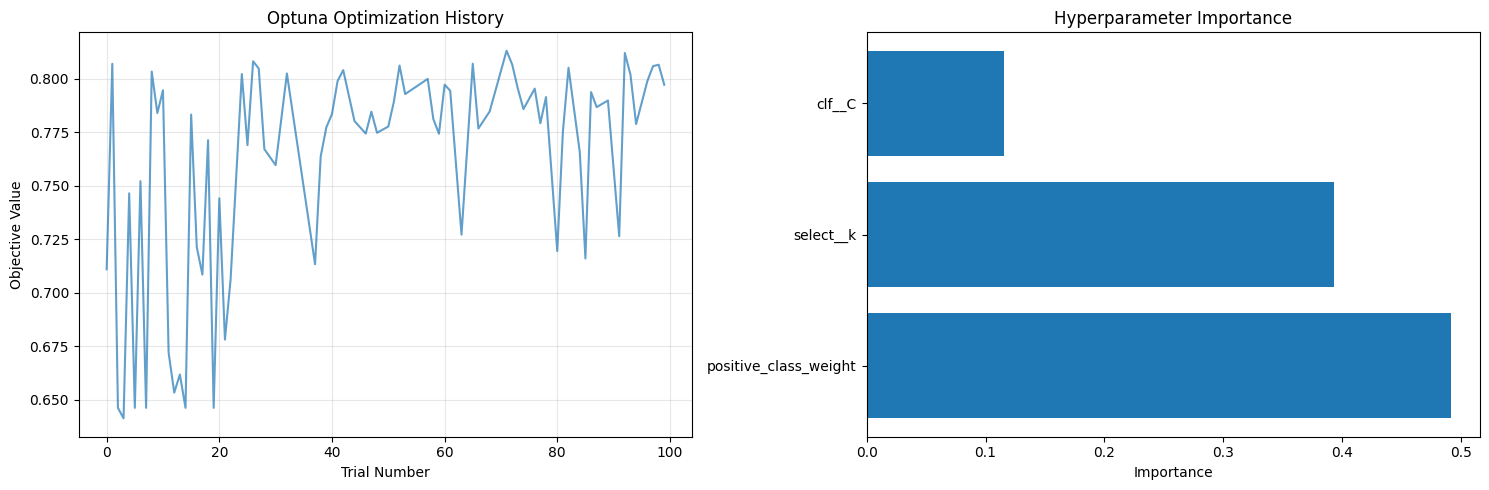


2. Parameter Value Distributions:


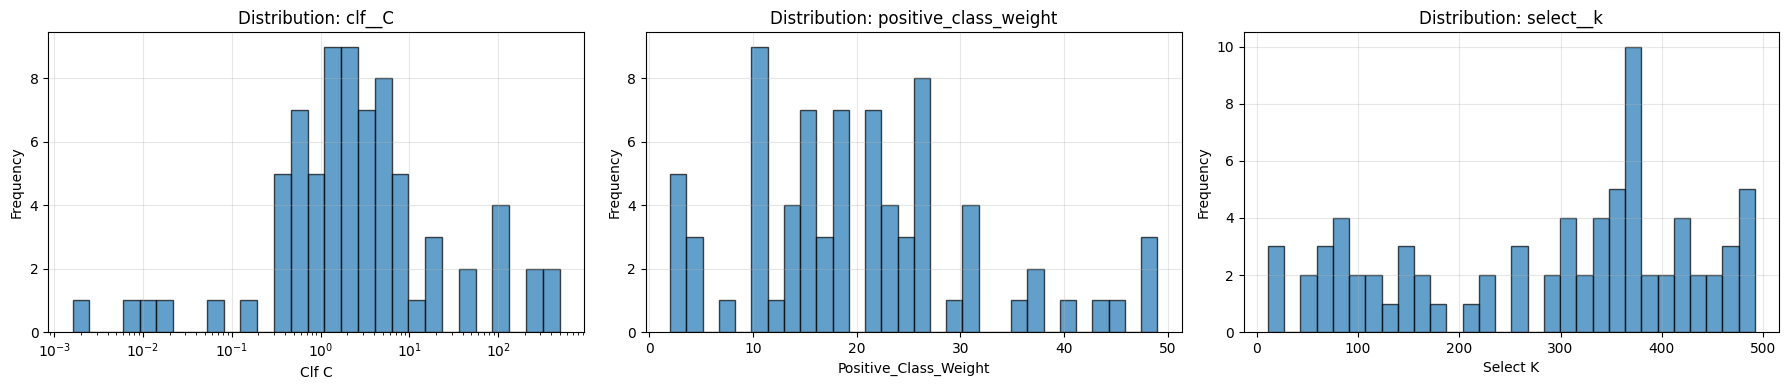


3. Performance vs Individual Parameters:


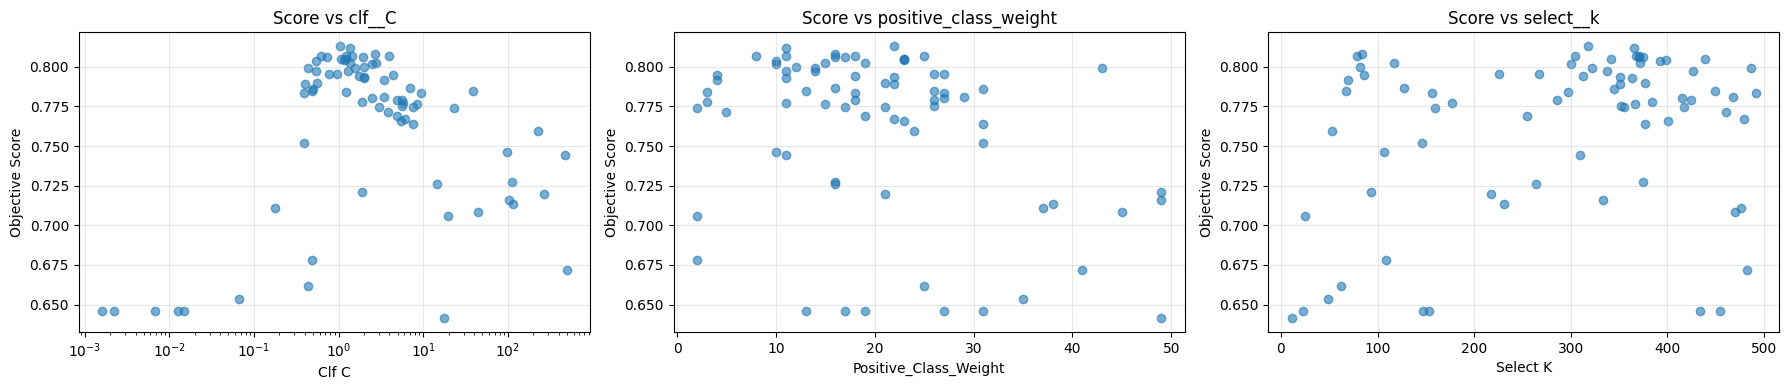


4. Convergence Analysis:


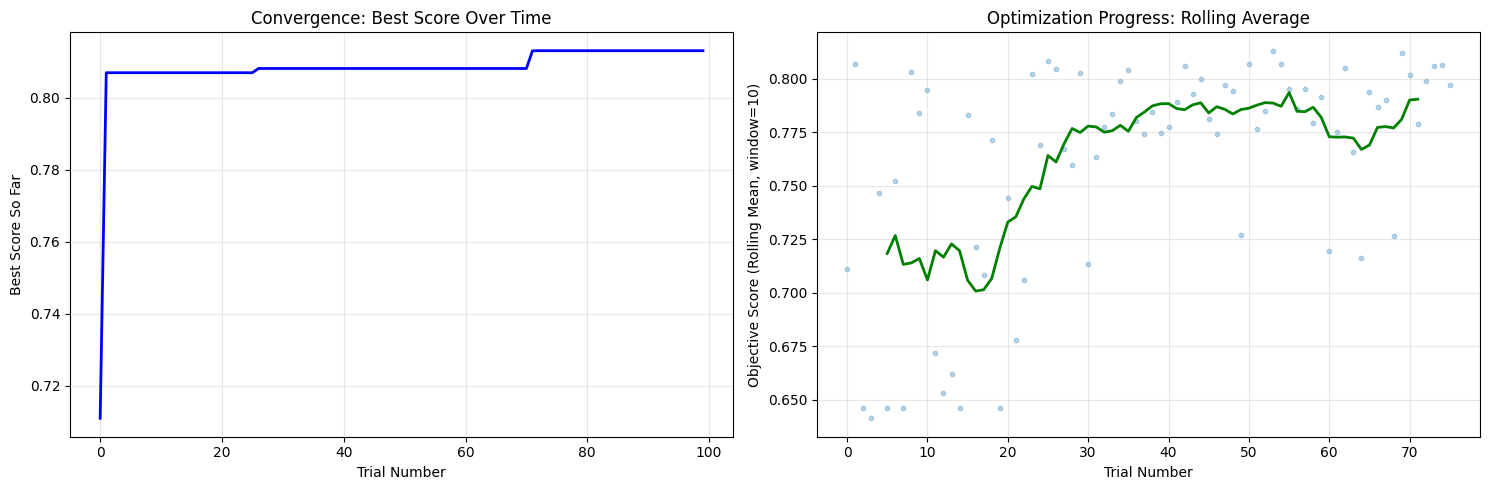


5. Trial Status Overview:


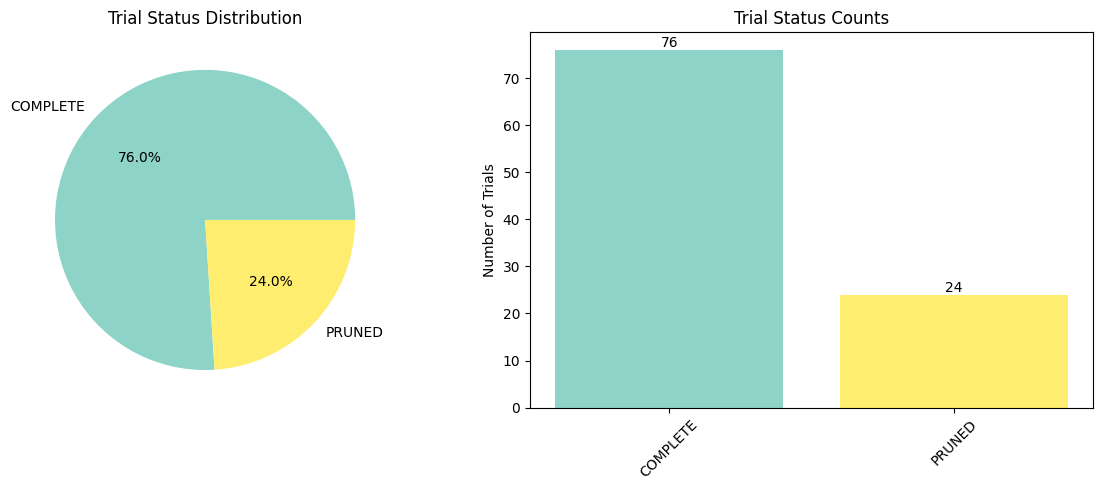


6. Top 10 Best Trials:
Rank Trial#  Score      C            positive_class_weight k           
-----------------------------------------------------------------------
1    71      0.8131     1.0326       22           318         
2    92      0.8120     1.3624       11           366         
3    26      0.8082     2.6667       16           84          
4    65      0.8070     1.4256       18           368         
5    1       0.8070     3.9080       8            79          
6    72      0.8067     1.2204       25           304         
7    98      0.8066     0.6277       11           371         
8    52      0.8062     1.9419       17           375         
9    97      0.8059     0.7220       16           371         
10   82      0.8051     1.2397       23           342         

7. Study Statistics Summary:
• Total trials: 100
• Successful trials: 76
• Failed trials: 0
• Success rate: 76.0%
• Best trial: #71
• Best objective value: 0.8131
• Score statistics:
  - Mean: 0.7365
 

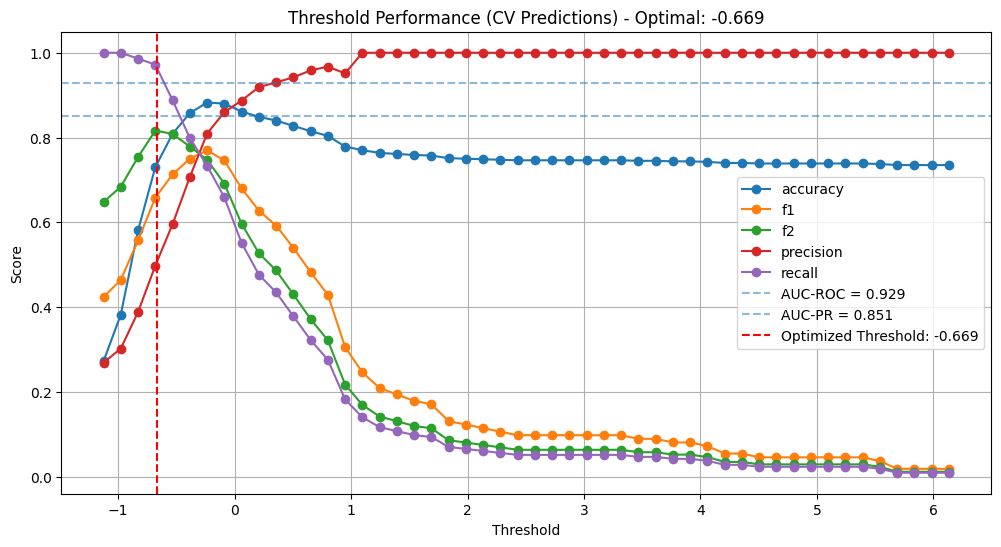

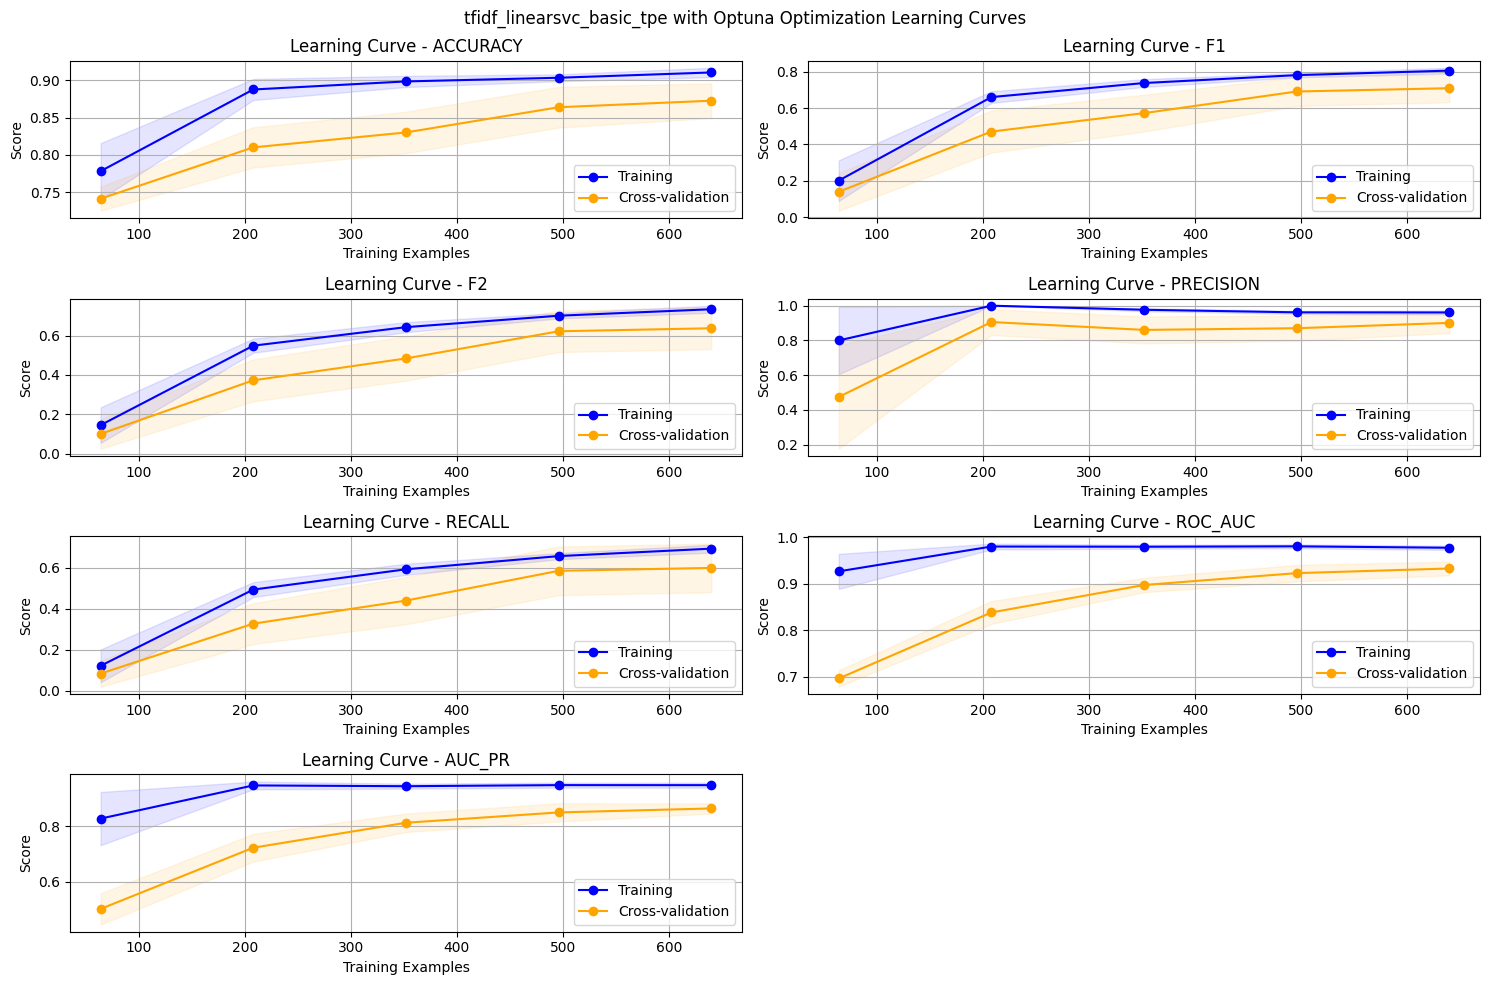


Final Threshold: -0.67
F2-score with default threshold (0.5): 0.363

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78       146
           1       0.50      0.89      0.64        54

    accuracy                           0.73       200
   macro avg       0.72      0.78      0.71       200
weighted avg       0.82      0.73      0.75       200

Additional Metrics:
Accuracy   0.730
F2-score   0.769
AUC-ROC    0.901
AUC-PR     0.796



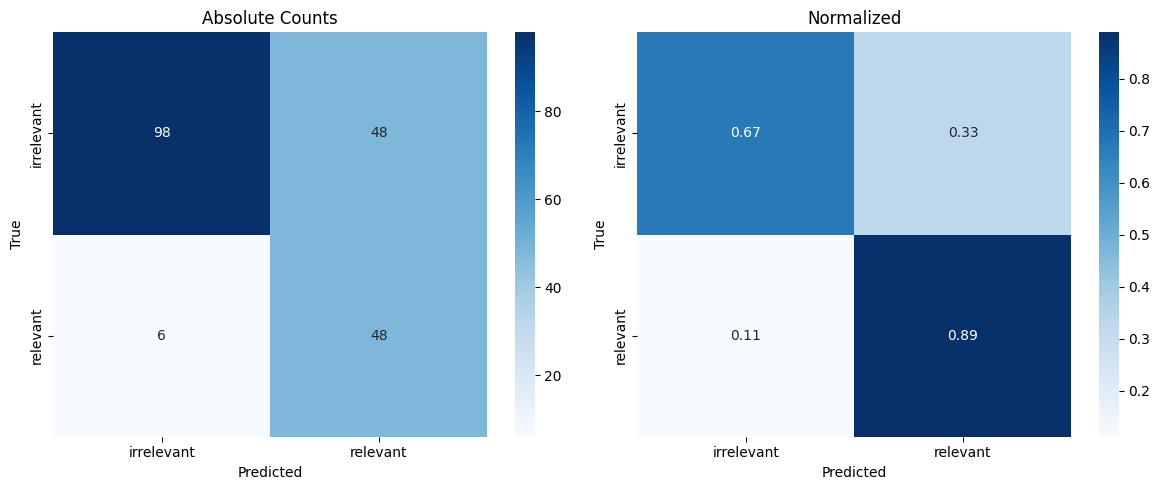

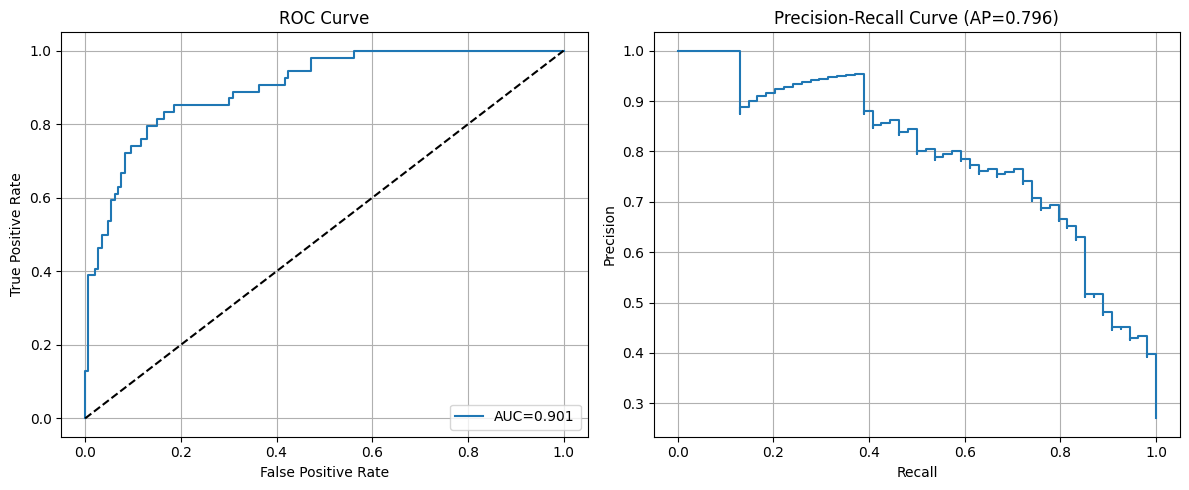


Model saved as model_tfidf_linearsvc_basic_tpe.joblib


In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a LinearSVC classifier 
pipeline_tfidf_linearsvc = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    random_state=42,
                    max_iter=50000 #iter warning
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e+3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 1, 500, step=1),
    "clf__class_weight": lambda trial: {0: 1, 1: sample_class_weight_value(trial, low=1, high=50, step=1)}
}

model_name = "tfidf_linearsvc_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_linearsvc,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "svm",
    n_trials=100,  # Intelligent search with early stopping
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

GridSearch

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 1.0, 'clf__class_weight': {0: 1, 1: 11}, 'select__k': 370}
Best F2 score during optimization: 0.816

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


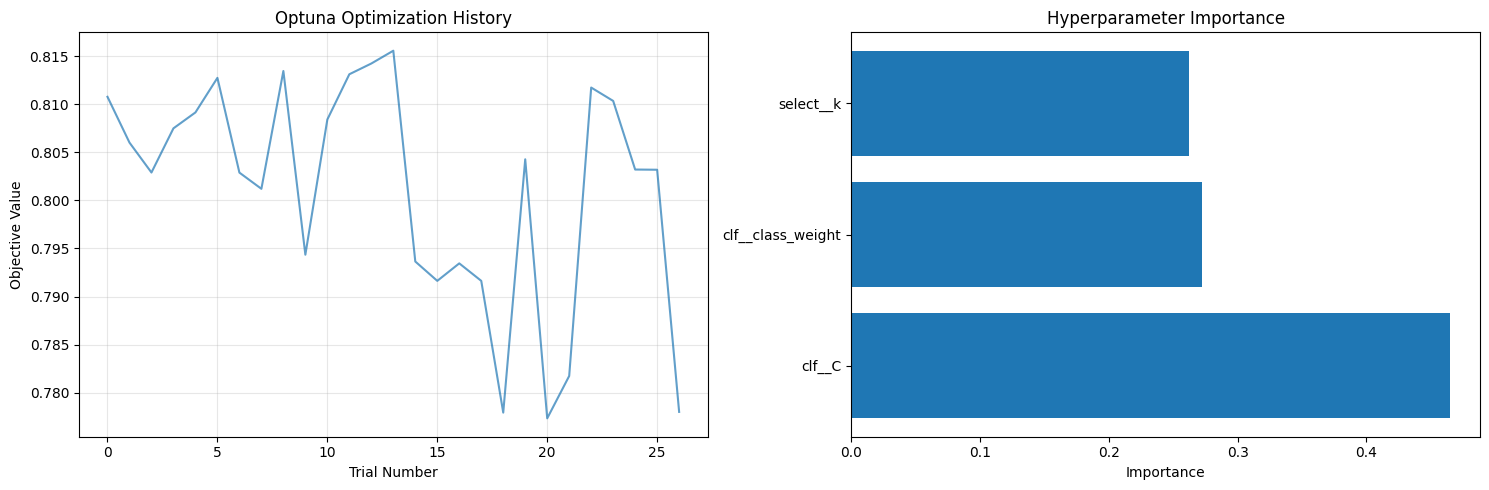


2. Parameter Value Distributions:


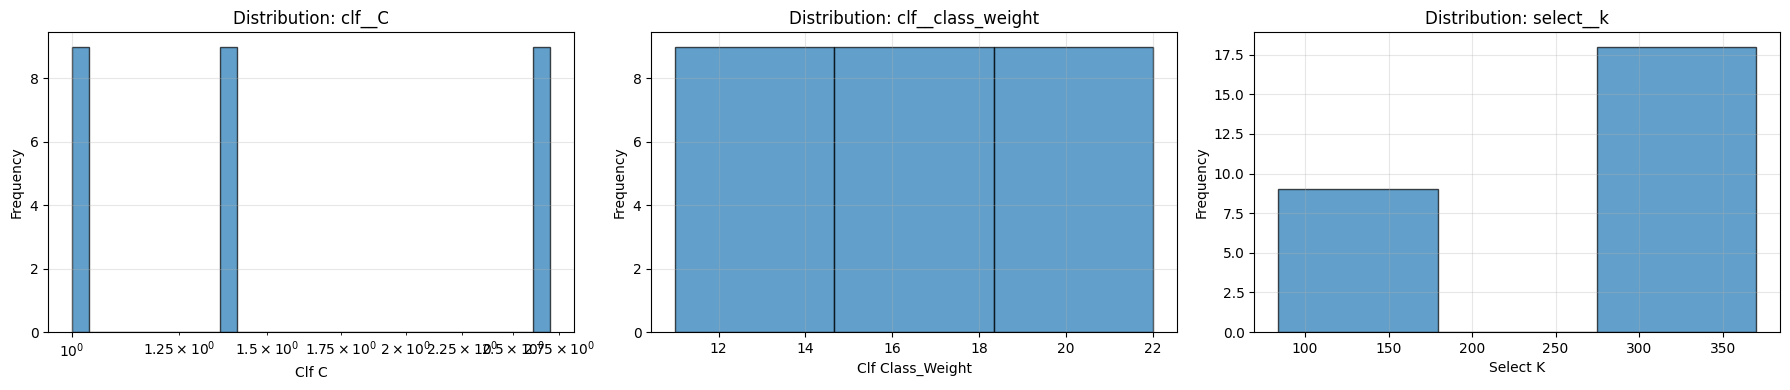


3. Performance vs Individual Parameters:


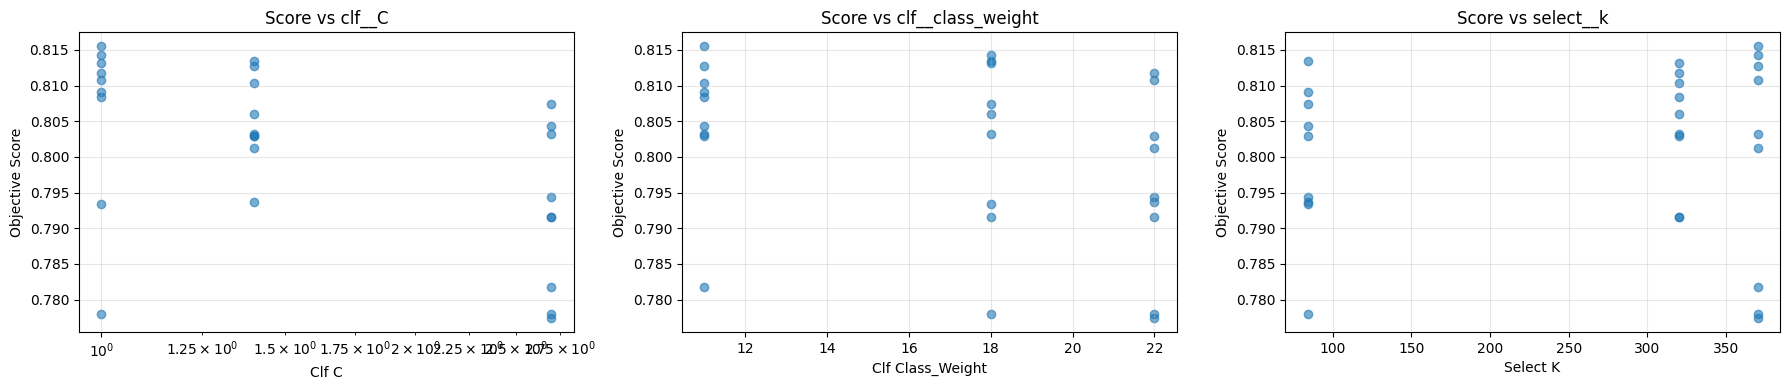


4. Convergence Analysis:


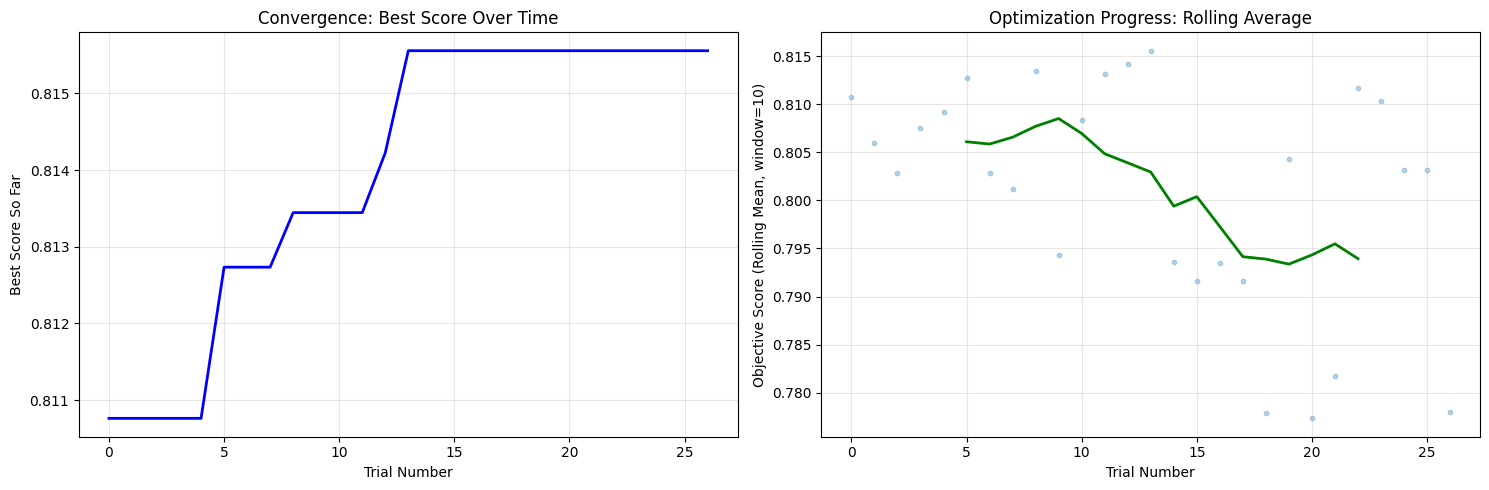


5. Trial Status Overview:


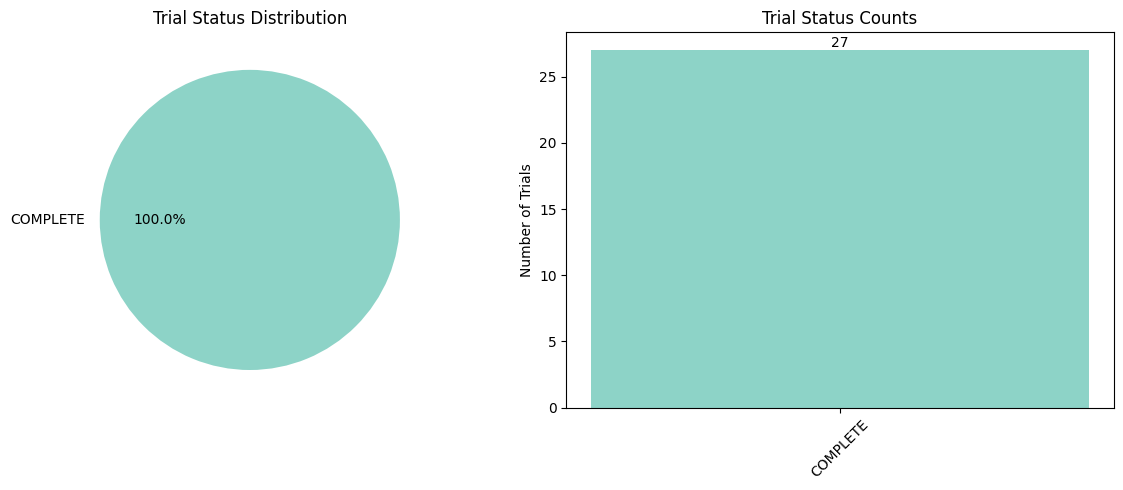


6. Top 10 Best Trials:
Rank Trial#  Score      C            class_weight k           
--------------------------------------------------------------
1    13      0.8156     1.0000       11           370         
2    12      0.8142     1.0000       18           370         
3    8       0.8134     1.4000       18           84          
4    11      0.8131     1.0000       18           320         
5    5       0.8127     1.4000       11           370         
6    22      0.8117     1.0000       22           320         
7    0       0.8108     1.0000       22           370         
8    23      0.8103     1.4000       11           320         
9    4       0.8091     1.0000       11           84          
10   10      0.8084     1.0000       11           320         

7. Study Statistics Summary:
• Total trials: 27
• Successful trials: 27
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #13
• Best objective value: 0.8156
• Score statistics:
  - Mean: 0.8011
  - Std:  0.0116
  

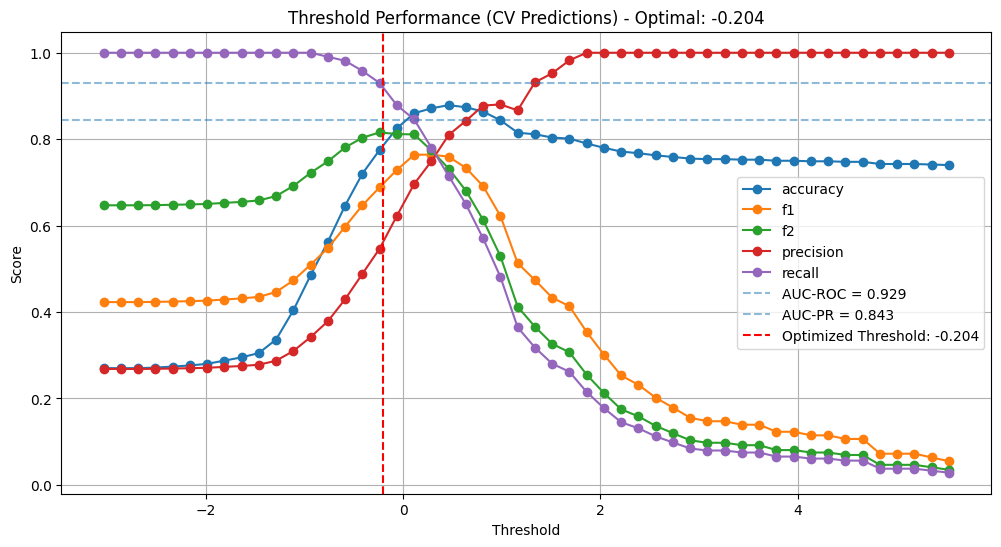

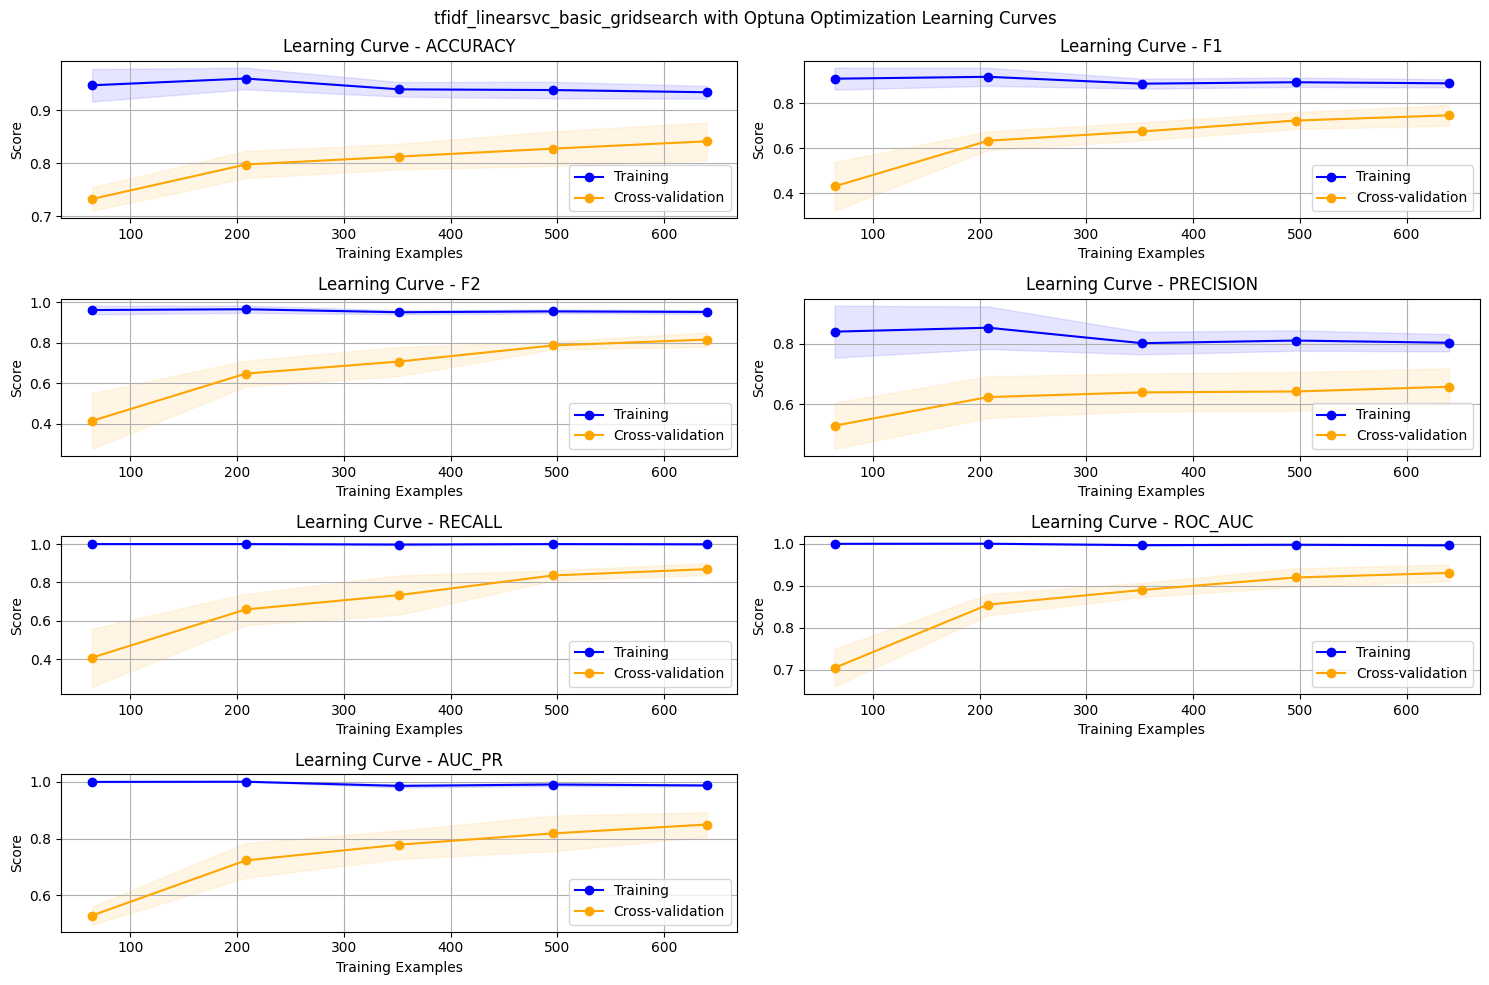


Final Threshold: -0.20
F2-score with default threshold (0.5): 0.586

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       146
           1       0.50      0.80      0.61        54

    accuracy                           0.73       200
   macro avg       0.70      0.75      0.70       200
weighted avg       0.79      0.73      0.74       200

Additional Metrics:
Accuracy   0.730
F2-score   0.712
AUC-ROC    0.862
AUC-PR     0.728



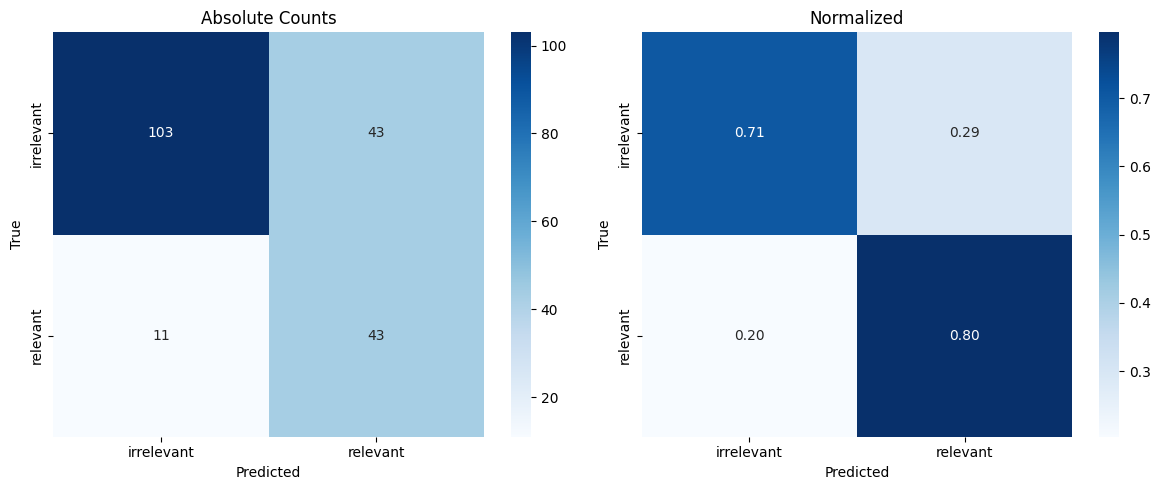

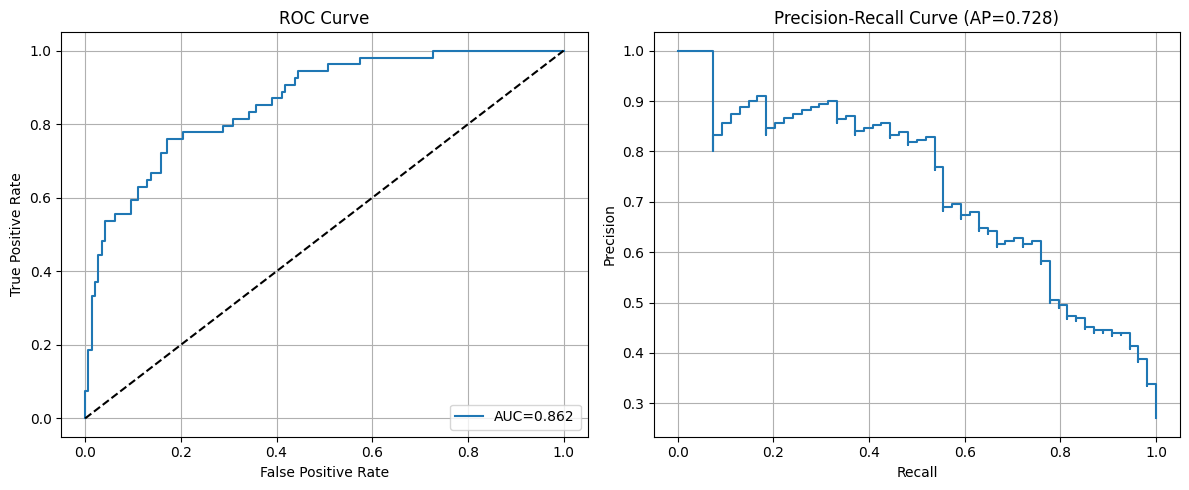


Model saved as model_tfidf_linearsvc_basic_gridsearch.joblib


In [4]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Pipeline 
pipeline_tfidf_logreg = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    random_state=42,
                    max_iter=50000
                ))
]) 

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

#for coarse approach
param_grid = {
    "clf__C":            [1.0, 1.4, 2.7],   # around best (~1.03) + tails (~1.3–1.5, ~2.6–2.7)
    "clf__class_weight": [11, 18, 22],      # top cluster ~11–22 (best=22) — map to {0:1,1:w}
    "select__k":         [84, 320, 370],    # two modes: small (~80) and large (~300–380); peak ~318
}


model_name = "tfidf_linearsvc_basic_gridsearch"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_logreg,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)


print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")


# Show optimization history/statistics
plot_optuna_study_analysis(study) 

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': {model_name},
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

**b) with advanced preprocessed data**

In [5]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # advanced cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

TPE Search

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__C': 1.6937954792775436, 'select__k': 163, 'positive_class_weight': 27, 'phrases__enable': True, 'phrases__min_count': 77, 'phrases__threshold': 9.547609386211823}
Best F2 score during optimization: 0.872

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


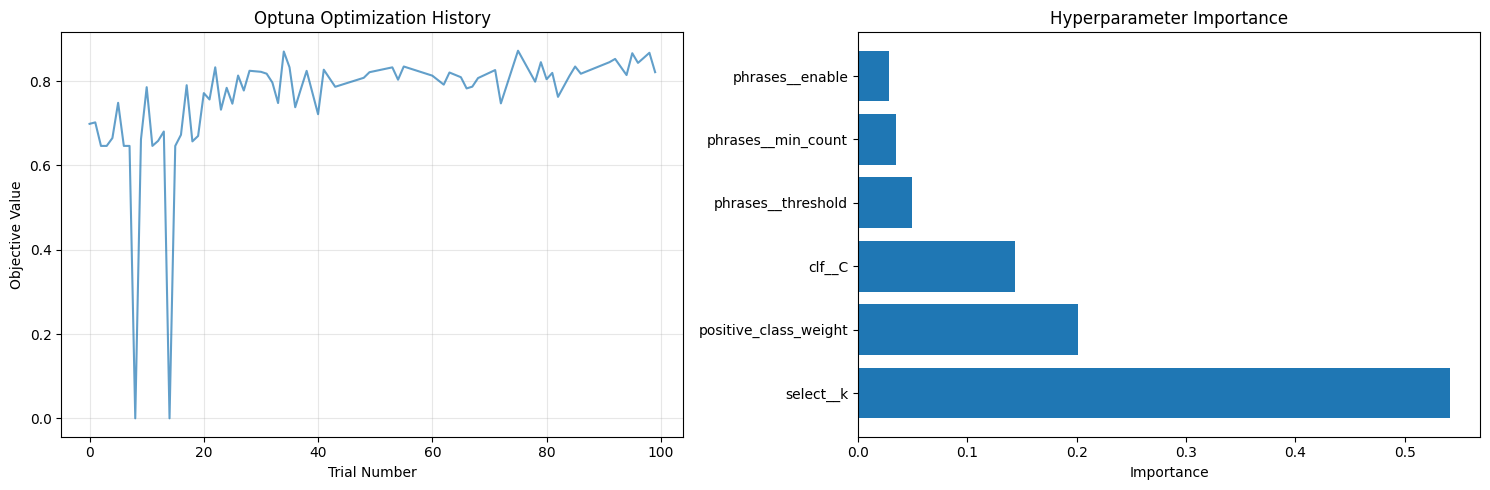


2. Parameter Value Distributions:


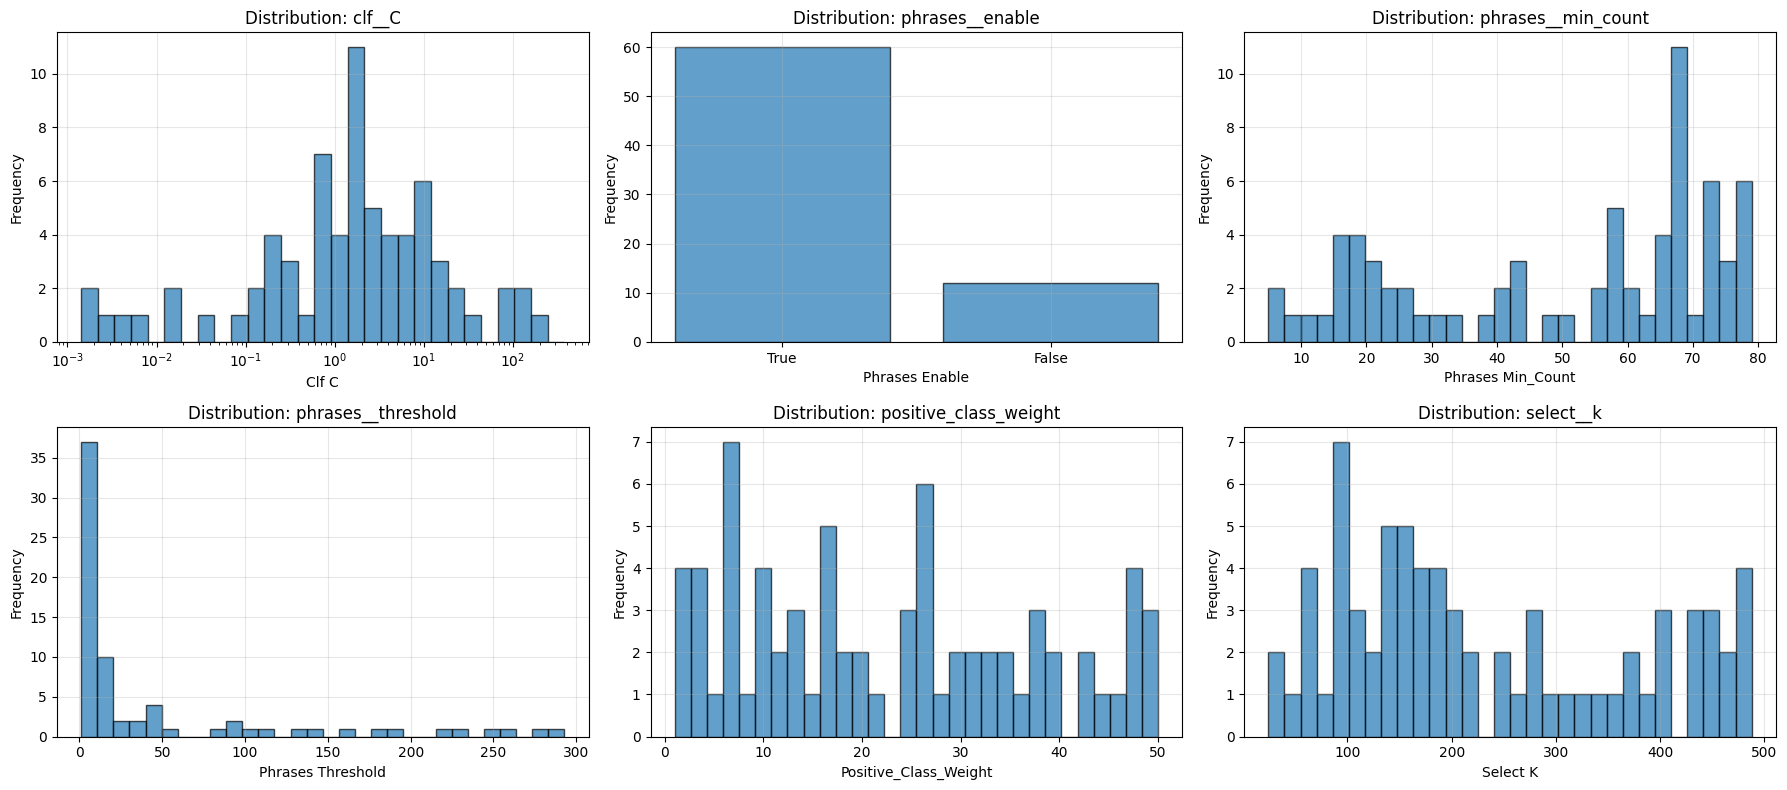


3. Performance vs Individual Parameters:


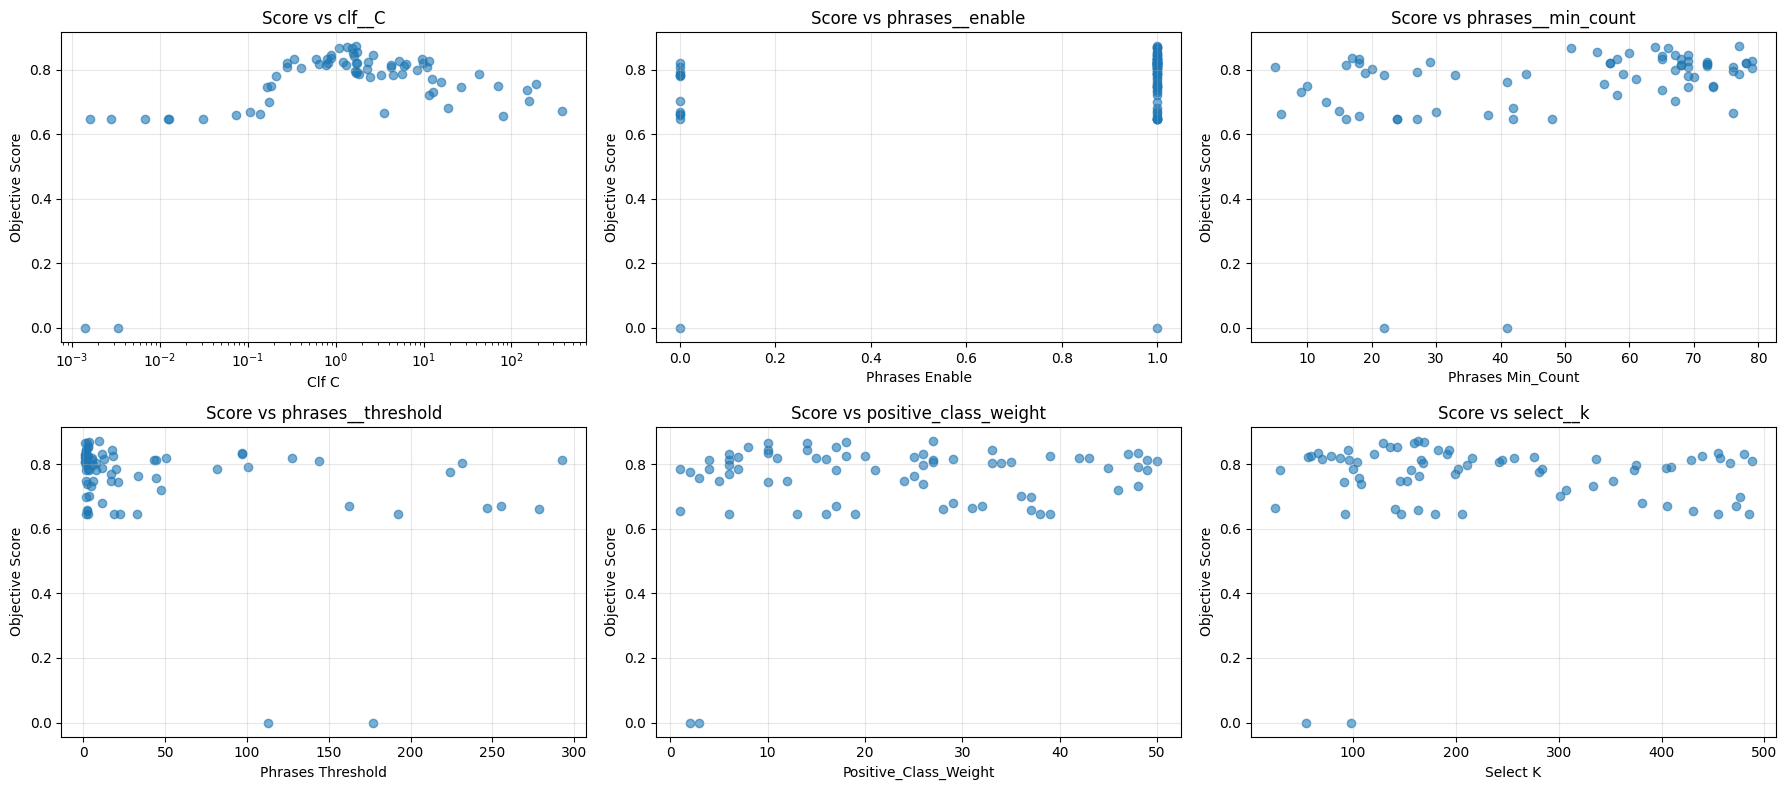


4. Convergence Analysis:


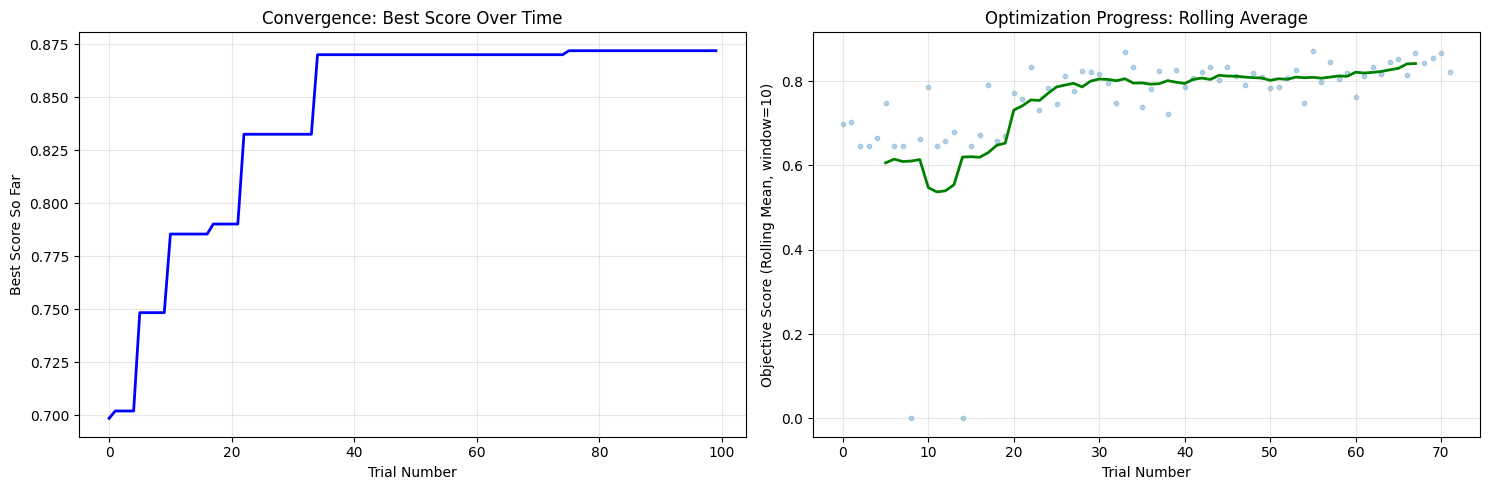


5. Trial Status Overview:


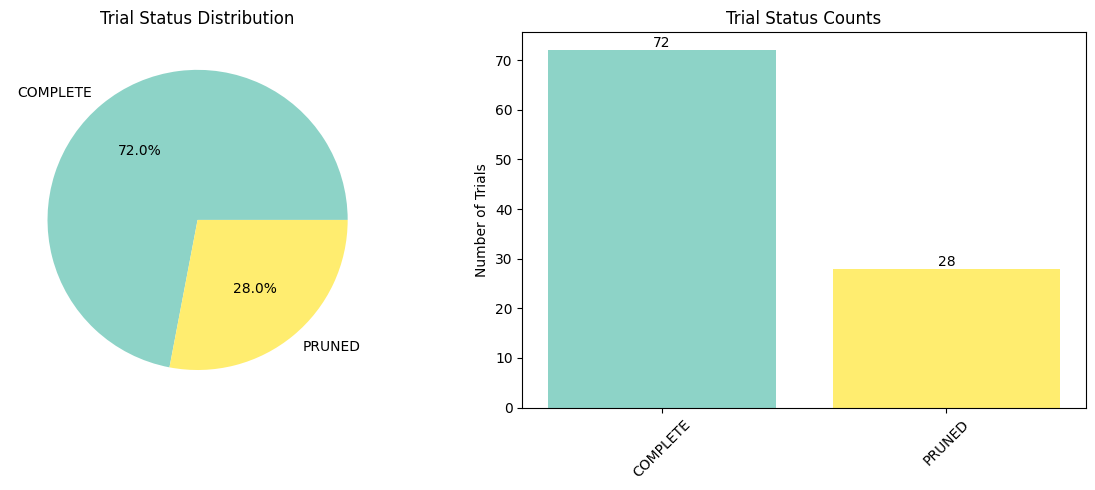


6. Top 10 Best Trials:
Rank Trial#  Score      C            enable       min_count    threshold    positive_class_weight k           
--------------------------------------------------------------------------------------------------------------
1    75      0.8719     1.6938       True         77           9.5476       27           163         
2    34      0.8700     1.3473       True         64           3.3625       18           169         
3    98      0.8670     1.5525       True         51           2.2934       10           129         
4    95      0.8660     1.1022       True         66           1.1429       14           159         
5    97      0.8548     1.7329       True         55           2.7946       17           143         
6    92      0.8524     1.5707       True         60           2.6426       8            136         
7    79      0.8447     0.8868       True         67           17.2296      33           193         
8    91      0.8447     2.6559       Tru

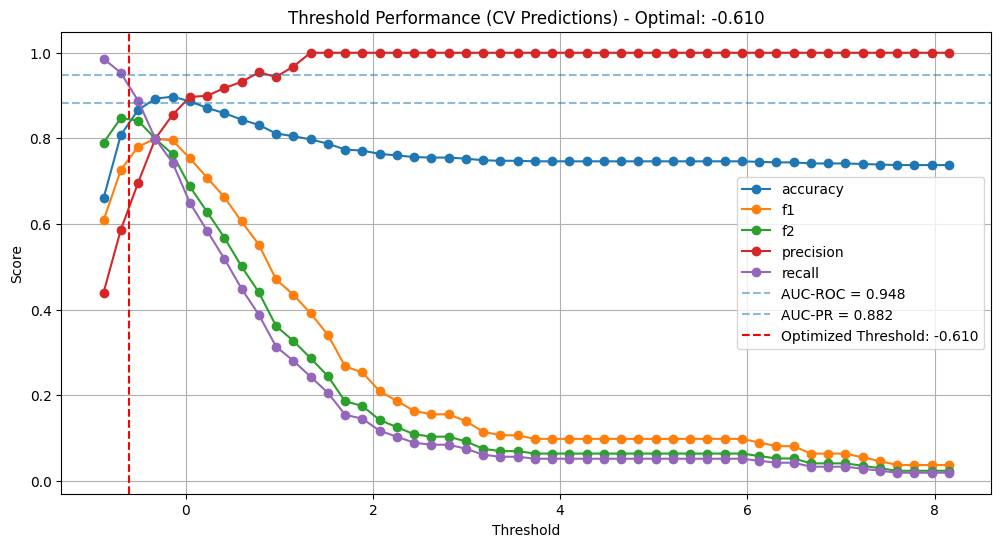

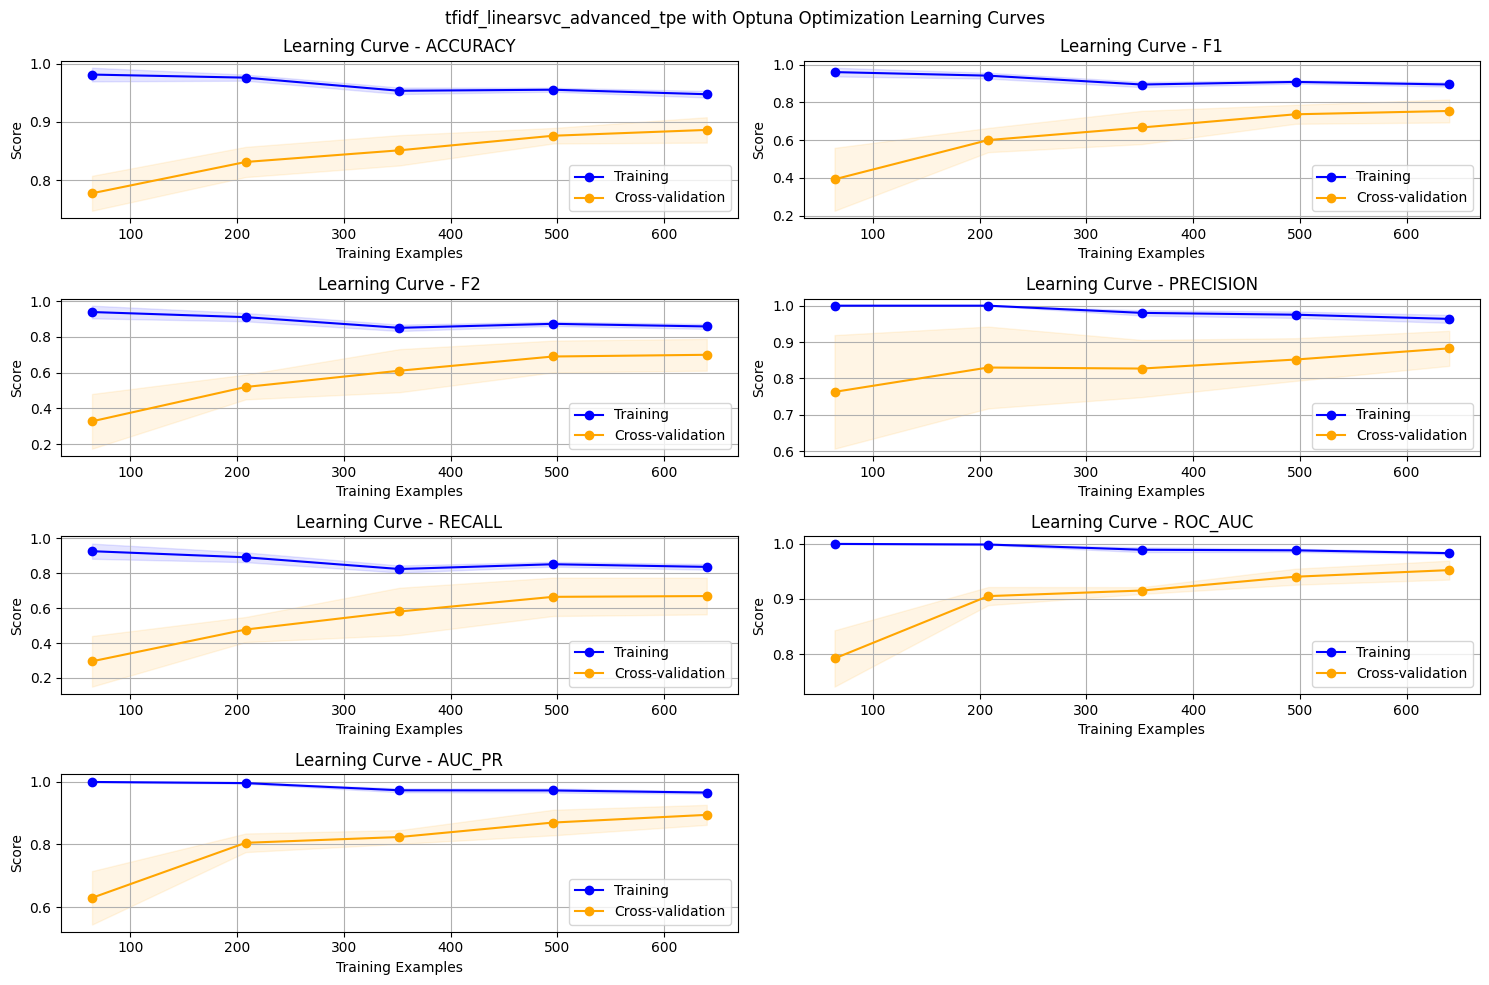


Final Threshold: -0.61
F2-score with default threshold (0.5): 0.528

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       146
           1       0.62      0.91      0.74        54

    accuracy                           0.82       200
   macro avg       0.79      0.85      0.80       200
weighted avg       0.87      0.82      0.83       200

Additional Metrics:
Accuracy   0.825
F2-score   0.831
AUC-ROC    0.919
AUC-PR     0.807



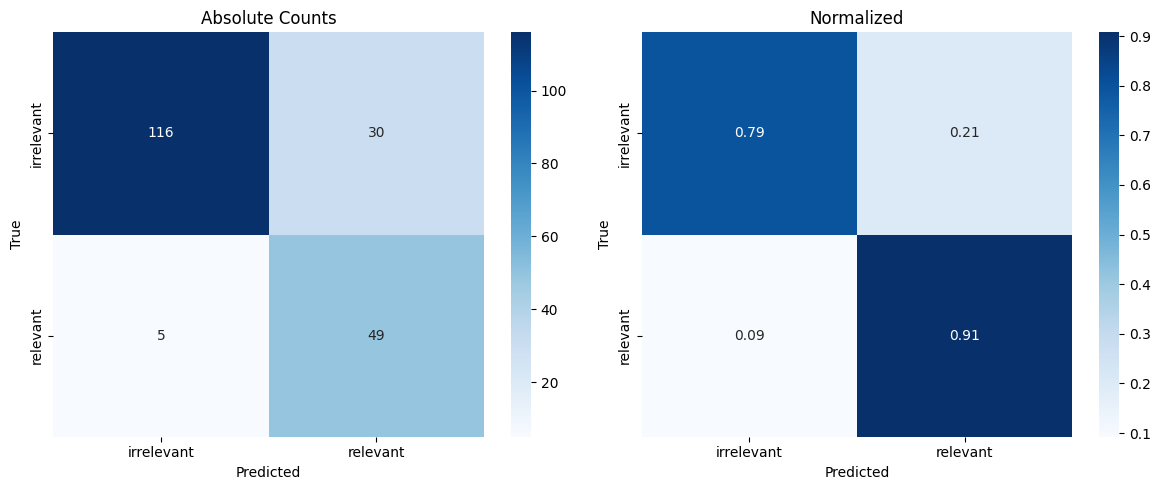

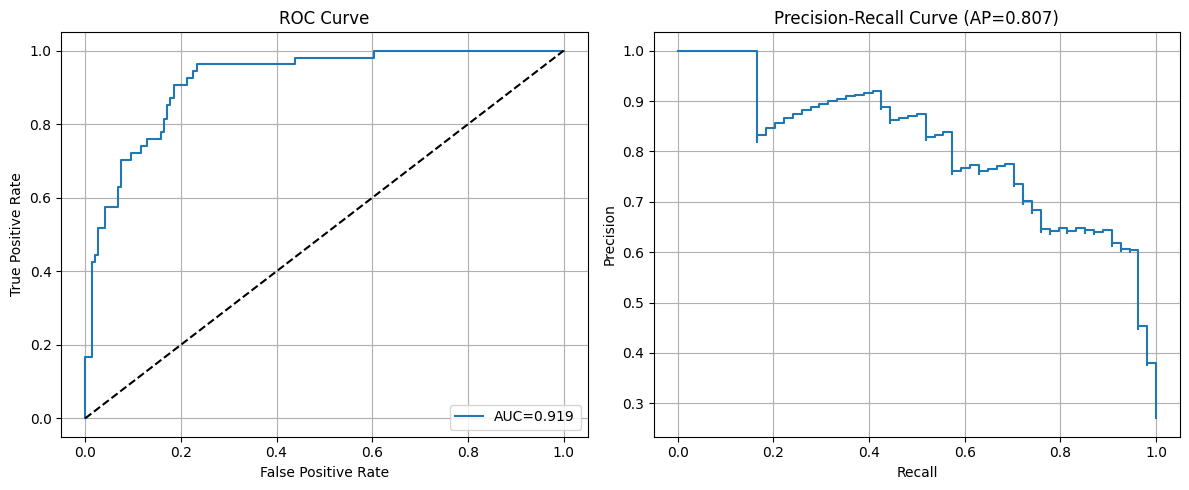


Model saved as model_tfidf_linearsvc_advanced_tpe.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],  # Fixed: use advanced data
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],  # Fixed: use advanced data
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a LinearSVC classifier 
pipeline_tfidf_linearsvc = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    random_state=42,
                    max_iter=50000 #iter warning
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 1, 500, step=1),
    "clf__class_weight": lambda trial: {0: 1, 1: sample_class_weight_value(trial, low=1, high=50, step=1)},
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [True, False]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_linearsvc_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_linearsvc,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "svm",
    n_trials=100,  # Intelligent search with early stopping
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

GridSearch

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 1.7, 'clf__class_weight': {0: 1, 1: 27}, 'select__k': 165, 'phrases__enable': True, 'phrases__min_count': 70, 'phrases__threshold': 12.0}
Best F2 score during optimization: 0.873

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


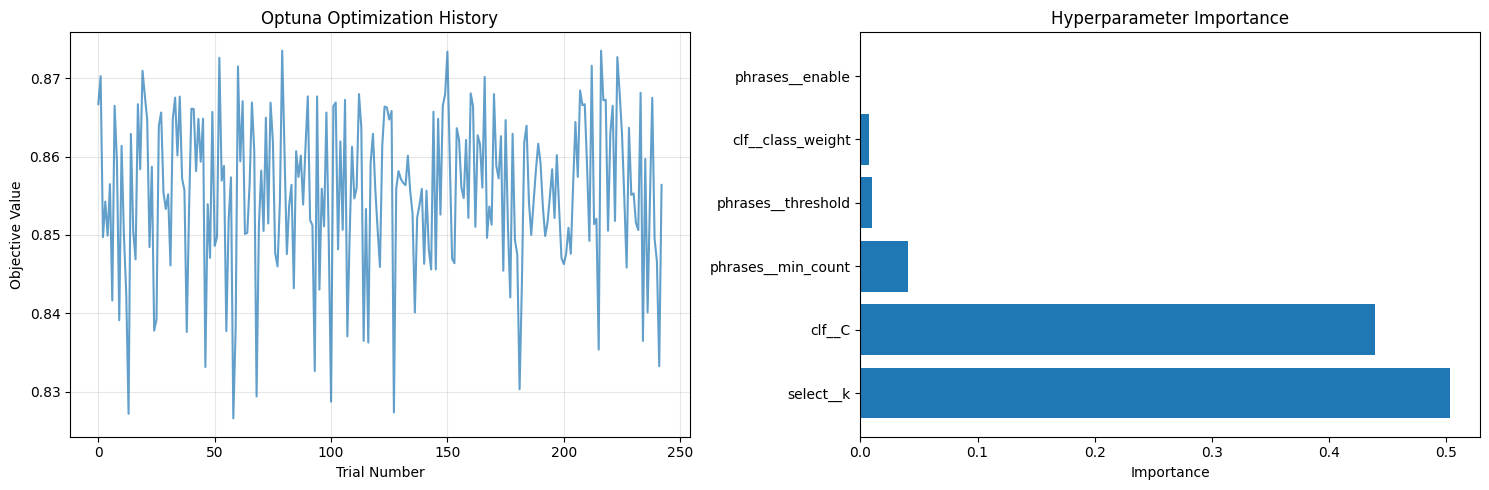


2. Parameter Value Distributions:


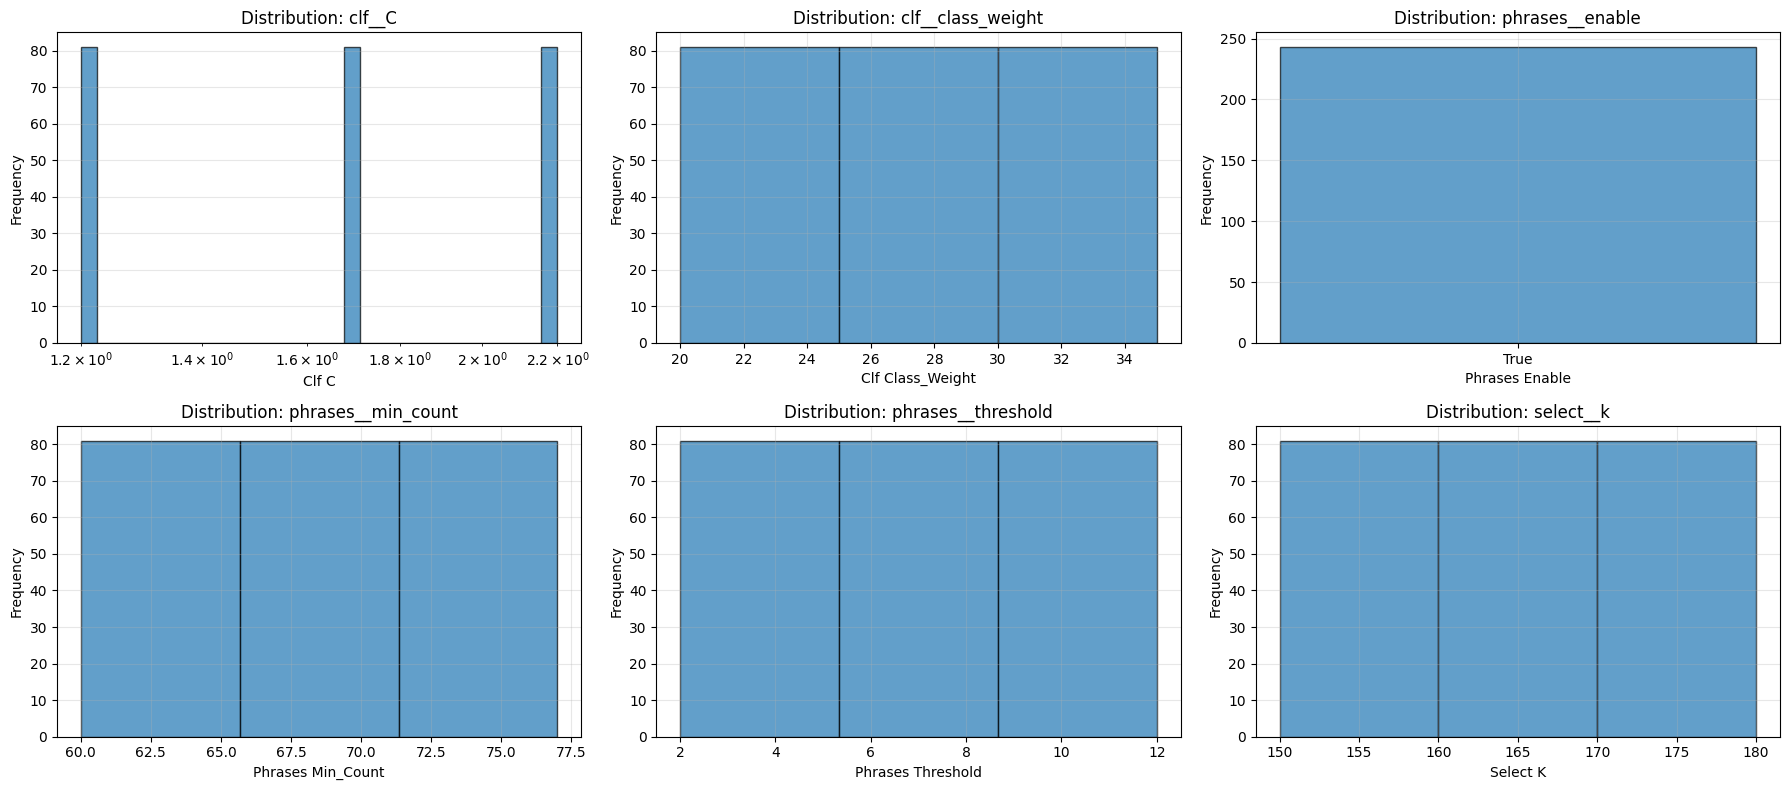


3. Performance vs Individual Parameters:


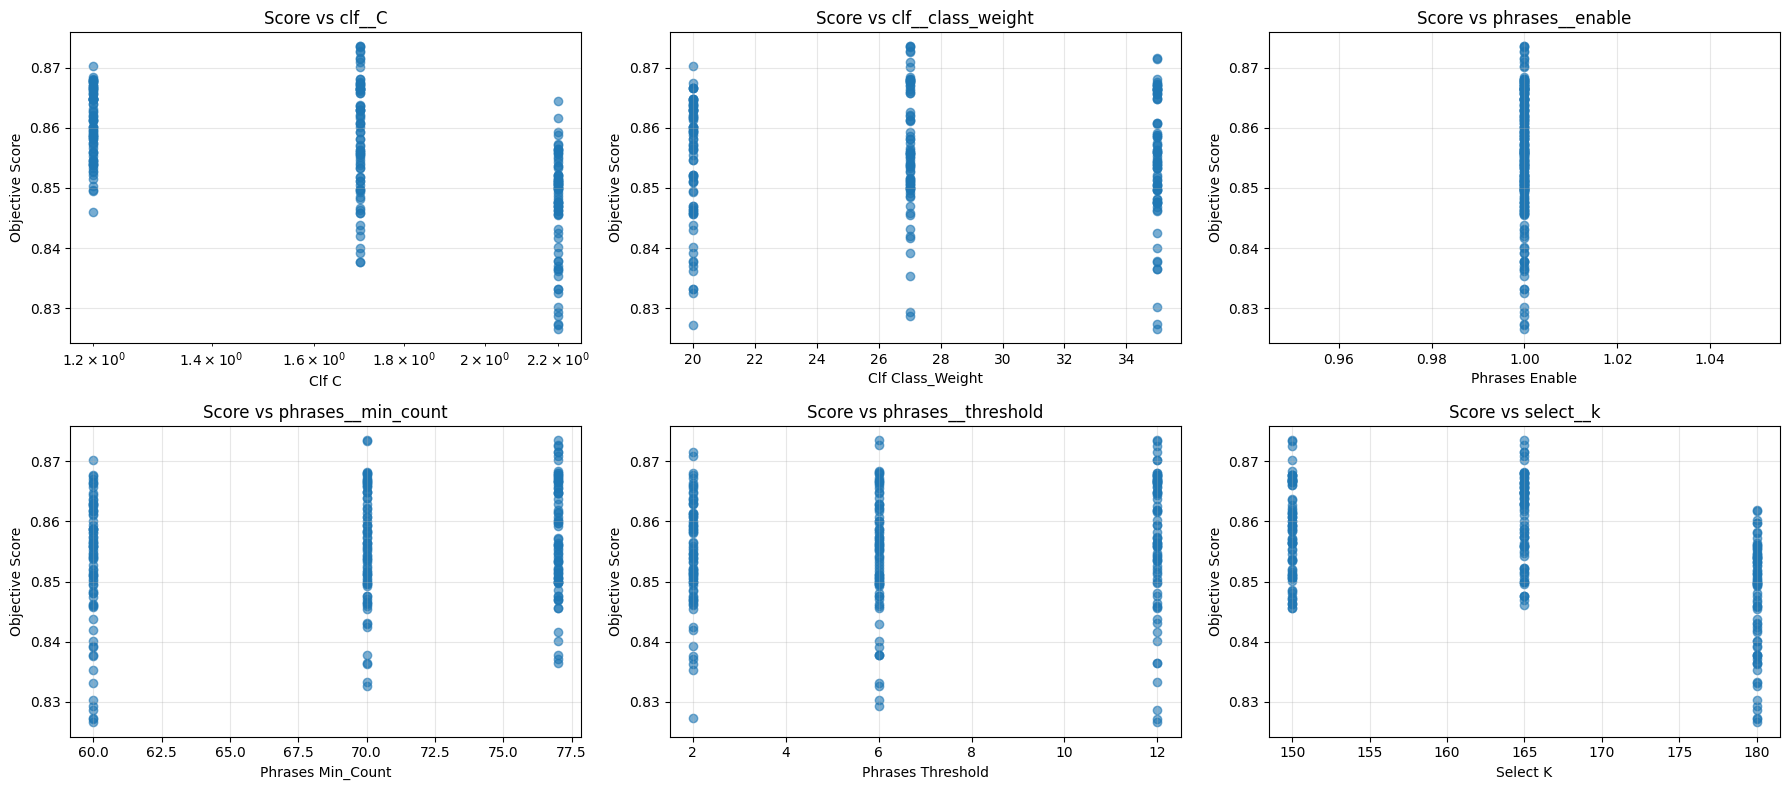


4. Convergence Analysis:


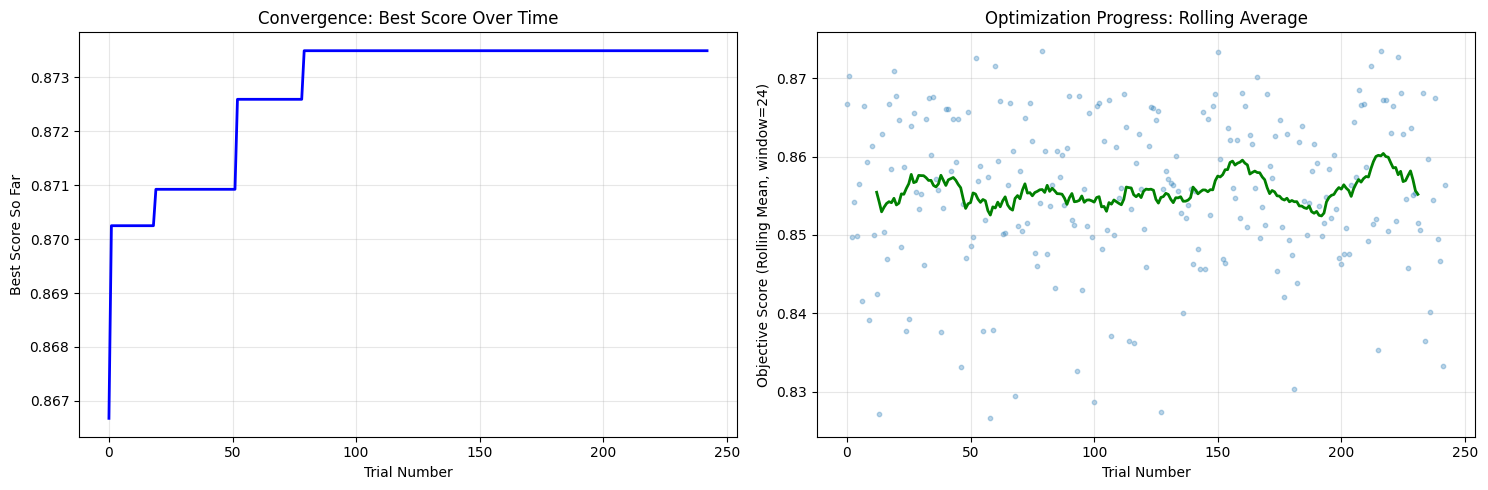


5. Trial Status Overview:


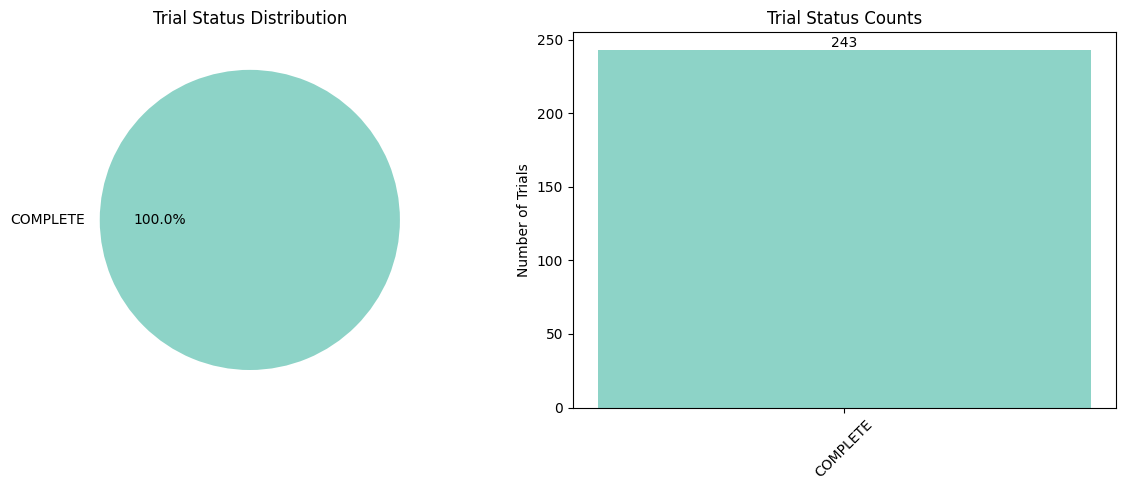


6. Top 10 Best Trials:
Rank Trial#  Score      C            class_weight enable       min_count    threshold    k           
-----------------------------------------------------------------------------------------------------
1    79      0.8735     1.7000       27           True         70           12.0000      165         
2    216     0.8735     1.7000       27           True         77           6.0000       150         
3    150     0.8734     1.7000       27           True         70           12.0000      150         
4    223     0.8727     1.7000       27           True         77           6.0000       165         
5    52      0.8726     1.7000       27           True         77           12.0000      150         
6    212     0.8716     1.7000       35           True         77           12.0000      165         
7    60      0.8715     1.7000       35           True         77           2.0000       165         
8    19      0.8709     1.7000       27           True    

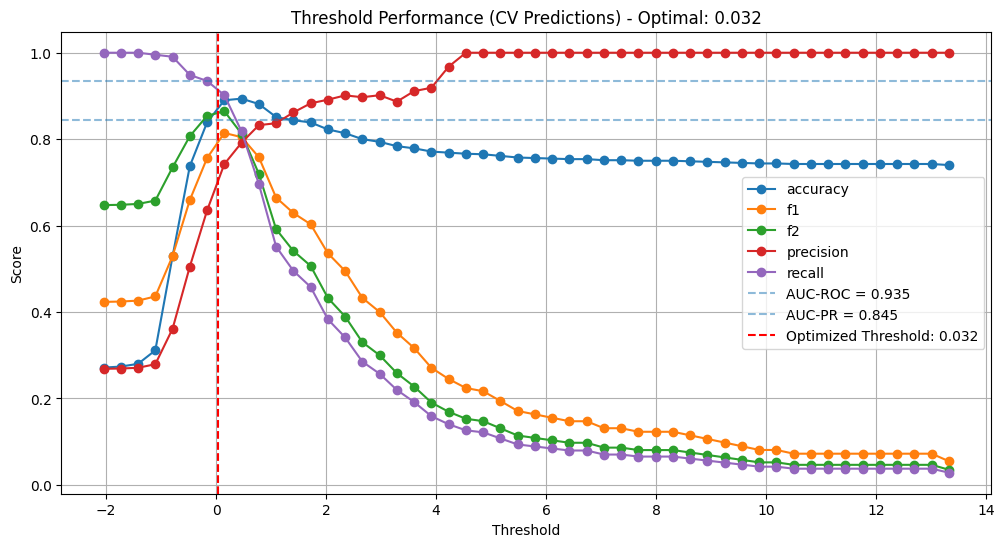

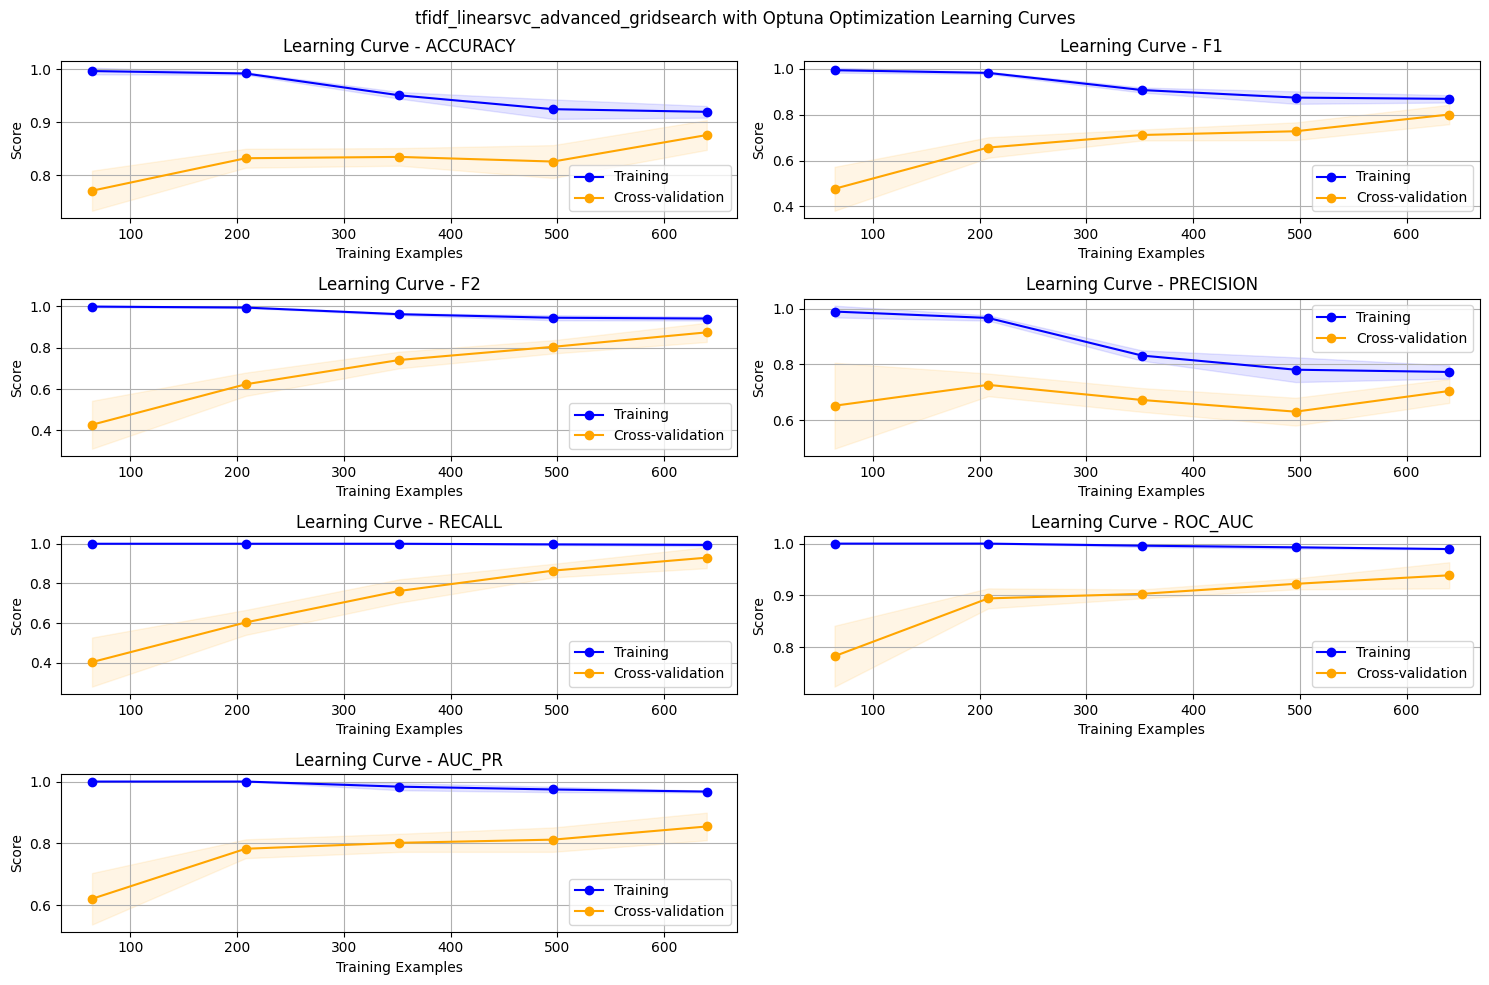


Final Threshold: 0.03
F2-score with default threshold (0.5): 0.733

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       146
           1       0.63      0.85      0.72        54

    accuracy                           0.82       200
   macro avg       0.78      0.83      0.80       200
weighted avg       0.85      0.82      0.83       200

Additional Metrics:
Accuracy   0.825
F2-score   0.796
AUC-ROC    0.892
AUC-PR     0.746



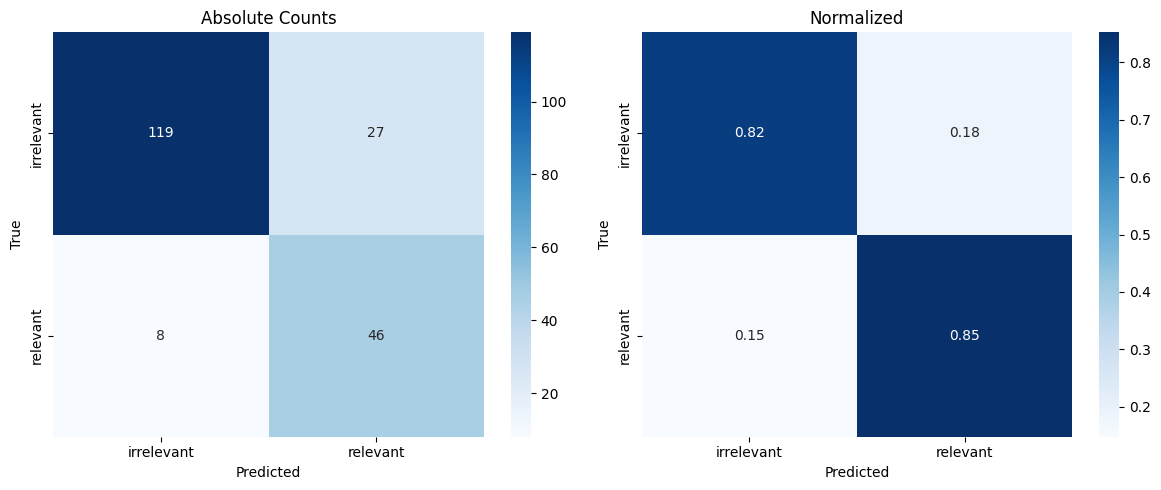

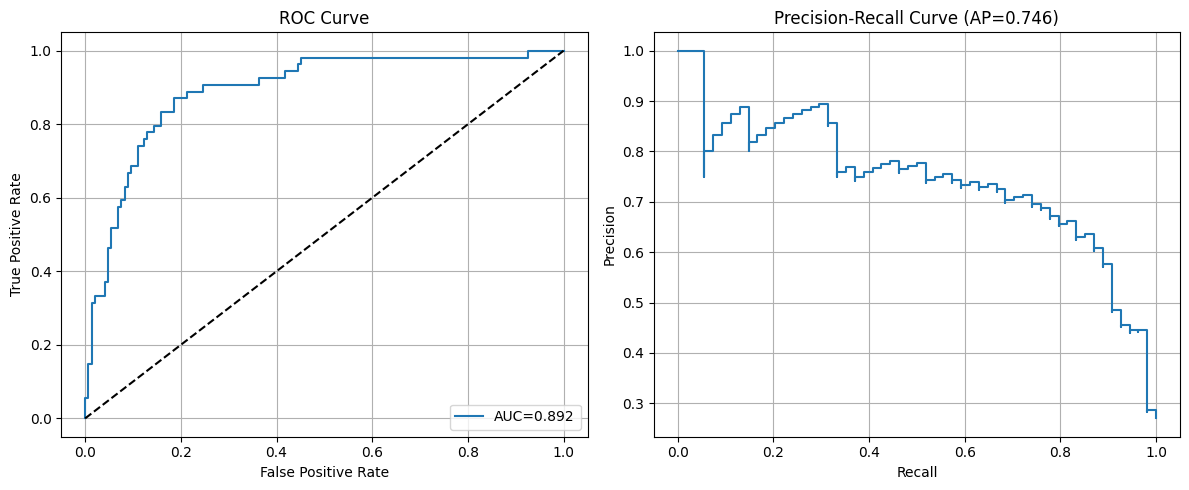


Model saved as model_tfidf_linearsvc_advanced_gridsearch.joblib


In [7]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],  # Fixed: use advanced data
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],  # Fixed: use advanced data
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a LinearSVC classifier 
pipeline_tfidf_linearsvc = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    random_state=42,
                    max_iter=500000 #iter warning
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

#for coarse approach
param_grid = {
    "clf__C": [1.2, 1.7, 2.2],                  # narrow around TPE peak (~1.7); plateau 1–3 in scatter
    "clf__class_weight": [20, 27, 35],          # best ≈27; try ±window to cover nearby class-imbalance sweet spot
    "select__k": [150, 165, 180],               # strongest driver; cluster 129–193 with best ~163 → tight bracket
    "phrases__enable": [True],                  # all top trials used phrases=True → lock for GS
    "phrases__min_count": [60, 70, 77],         # high end works best (51–77 band); include exact 77
    "phrases__threshold": [2.0, 6.0, 12.0],     # low-threshold sweet spot; log-ish spread around best (~9.5)
}

model_name = "tfidf_linearsvc_advanced_gridsearch"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_linearsvc,  # Fixed: use correct pipeline variable
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)


print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")


# Show optimization history/statistics
plot_optuna_study_analysis(study) 

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")